In [1]:
# main 
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# viz
import matplotlib.pyplot as plt
%matplotlib inline

# deal with warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set path
path = '/kaggle/input/playground-series-s4e5'

# load data
train = pd.read_csv(f'{path}/train.csv', index_col=0)
test = pd.read_csv(f'{path}/test.csv', index_col=0)

# Features

In [3]:
def stat_features(data, only_stat=False):
    """
    A lot of statistic features
    """
    df = data.copy()
    cols = df.columns
    
    df['sum'] = df[cols].sum(axis=1) 
    # df['mean'] = df[cols].mean(axis=1) # Same info as mean 1 corr
    df['std'] = df[cols].std(axis=1)
    df['median'] = df[cols].median(axis=1)
    df['min_all'] = df[cols].min(axis=1)
    df['max_all'] = df[cols].max(axis=1)
    df['ptp'] = df[cols].values.ptp(axis=1)
    df['q25'] = df[cols].quantile(0.25, axis=1)
    df['q75'] = df[cols].quantile(0.75, axis=1)
    
    if only_stat:
        df = df.drop(columns=cols)
        
    return df


In [4]:
train.head(3)

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530


In [5]:
test.head(3)

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
id,,,,,,,,,,,,,,,,,,,,
1117957,4,6,3,5,6,7,8,7,8,4,8,5,7,5,6,3,6,4,4,5
1117958,4,4,2,9,5,5,4,7,5,4,2,4,7,4,5,1,7,4,4,3
1117959,1,3,6,5,7,2,4,6,4,2,7,9,2,5,5,2,3,6,8,3


In [6]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

X_train_full = train.drop(columns = ['FloodProbability'])
y_train_full = train[['FloodProbability']].copy()

X_train_full = stat_features(data=X_train_full)
X_test = stat_features(data=test)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

# # StratifiedShuffleSplit
# splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
# train_idx, val_idx = next(splitter.split(X_train_full, y_train_full))

# X_train, y_train = X_train_full.iloc[train_idx], y_train_full.iloc[train_idx]
# X_val, y_val = X_train_full.iloc[val_idx], y_train_full.iloc[val_idx]


print(f'train_shape {X_train.shape},\n val_shape {X_val.shape}')

train_shape (1006161, 28),
 val_shape (111796, 28)


# Building mlp model

In [7]:
import tensorflow as tf
import keras_tuner as kt

2024-05-21 09:23:56.158507: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 09:23:56.158643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 09:23:56.305996: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
tf.keras.backend.clear_session()

## BaseLine MLP model
building model using sequantial API

In [9]:
tf.random.set_seed(42)

norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(50, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(50, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(50, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 28)             │            57 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         1,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,208 (35.97 KB)

 Trainable params: 9,151 (35.75 KB)

 Non-trainable params: 57 (232.00 B)

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='mse', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.R2Score])
norm_layer.adapt(X_train.values)

history = model.fit(X_train, 
                    y_train,
                    epochs=3, 
                    validation_data=(X_val, y_val))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss='mse', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.R2Score])
norm_layer.adapt(X_train.values)

history = model.fit(X_train, 
                    y_train,
                    batch_size=256,
                    epochs=3, 
                    validation_data=(X_val, y_val))

Epoch 1/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 0.0030 - r2_score: -0.1555 - val_loss: 3.8189e-04 - val_r2_score: 0.8531
Epoch 2/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 3.8045e-04 - r2_score: 0.8540 - val_loss: 3.6373e-04 - val_r2_score: 0.8601
Epoch 3/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 3.6837e-04 - r2_score: 0.8587 - val_loss: 3.6064e-04 - val_r2_score: 0.8613
Epoch 1/3
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 3.6007e-04 - r2_score: 0.8619 - val_loss: 3.5837e-04 - val_r2_score: 0.8622
Epoch 2/3
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 3.5945e-04 - r2_score: 0.8621 - val_loss: 3.5816e-04 - val_r2_score: 0.8622
Epoch 3/3
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 3.5920e-04 - r2_score: 0.8622 - val_loss: 3.5802e-04 - val_r2_score: 0.8623


In [11]:
y_pred = model.predict(X_test.values)

23291/23291 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step


<Axes: ylabel='Count'>

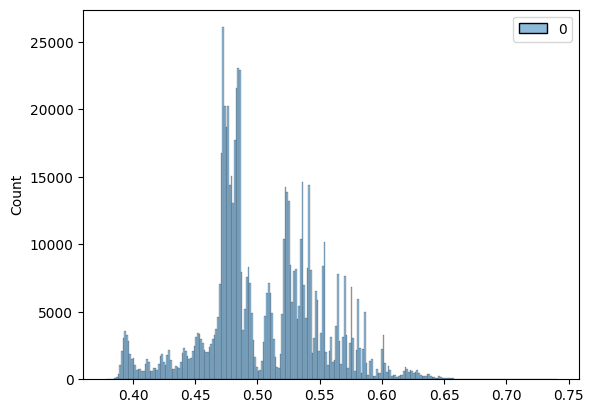

In [12]:
import seaborn as sns
sns.histplot(y_pred)

In [13]:
sub = pd.DataFrame({'FloodProbability': y_pred.reshape(-1)},
             index=test.index)
sub.to_csv('submission.csv', index=True)
